# Model building

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import functions.plots as plotting
import functions.model_functions as model_func
import functions.EDA_Functions as eda_func

## 1. Asset loading

### 1.1. Feature information

In [2]:
dataPath = "../data/raw/mergedNew_data.csv"
rfr_df = eda_func.load_data(dataPath)

In [3]:
biometric_features=[
    'Age', 'Gender', 'Height', 'Weight'
]

input_features={
    'calorie_model': ['Duration'] + biometric_features,
    'time_model': ['Calories'] + biometric_features
}

output_features={
    'calorie_model': 'Calories',
    'time_model': 'Duration'
}

### 1.2. Datasets

In [4]:
categorical_features=['Gender']

# Extract unique values from categorical features
categories_list = [
    rfr_df["Gender"].unique().tolist(),
]

df_encoded = eda_func.ordinal_encode_features(rfr_df, categorical_features)

print(df_encoded.head())

    User_ID  Calories  Gender  Age  Height  Weight  Duration  Heart_Rate  \
0  14733363     231.0     0.0   68   190.0    94.0      29.0       105.0   
1  14861698      66.0     1.0   20   166.0    60.0      14.0        94.0   
2  11179863      26.0     0.0   69   179.0    79.0       5.0        88.0   
3  16180408      71.0     1.0   34   179.0    71.0      13.0       100.0   
4  17771927      35.0     1.0   27   154.0    58.0      10.0        81.0   

   Body_Temp  
0       40.8  
1       40.3  
2       38.7  
3       40.5  
4       39.8  


In [5]:
train_df, test_df = model_func.split_data(df_encoded)

## 2. Model Building

We need to build two models - one to predict time and the other to predict calories. We will again use a dictionary to keep things organized.

### 2.1. Model dictionary definition

In [6]:
# Instead of using HistGradientBoostingRegressor for both models, Im assigning RandomForestRegressor to calorie_model while keeping Gradient Boosting for time_model.

models={
    'calorie_model': RandomForestRegressor(n_estimators=100, random_state=42), # Using RF for calorie prediction
    'time_model': HistGradientBoostingRegressor(early_stopping=True) # Keeping HGB for duration prediction
}

### 2.2. Naive model cross validation

In [7]:
# Since Im comparing Random Forest Regression (calorie_model) and HistGradientBoostingRegressor (time_model), I'll use cross-validation to test their performance before hyperparameter tuning.
# Ensures models perform well across different data subsets
# Provides a baseline RMSE before tuning hyperparameters
# Helps compare effectiveness of Random Forest vs. Gradient Boosting before optimization

cross_val_results={}

for model_name, model in models.items():
    X_train = train_df[input_features[model_name]]
    y_train = train_df[output_features[model_name]]

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")

    cross_val_results[model_name] = abs(scores.mean())

    print(f"{model_name} Naïve Cross-Validation RMSE: {cross_val_results[model_name]:.2f}")


calorie_model Naïve Cross-Validation RMSE: 12.67
time_model Naïve Cross-Validation RMSE: 1.37


In [8]:
# Train calorie_model
models["calorie_model"].fit(train_df[input_features["calorie_model"]], train_df[output_features["calorie_model"]])

# Train time_model
models["time_model"].fit(train_df[input_features["time_model"]], train_df[output_features["time_model"]])

HistGradientBoostingRegressor(early_stopping=True)

In [9]:
# Since I can't directly extract feature_importances_, I can use permutation_importance from sklearn.inspection, which evaluates how much each feature affects model performance

# Apply function for time_model
time_feature_importance = model_func.get_boosted_feature_importance(
    models["time_model"], 
    test_df[input_features["time_model"]], 
    test_df[output_features["time_model"]], 
    input_features["time_model"]
)

print("Time Model Feature Importance:\n", time_feature_importance)

Time Model Feature Importance:
     Feature  Importance
0  Calories    1.999162
1       Age    0.031916
2    Gender    0.010260
4    Weight    0.003149
3    Height    0.000230


In [10]:
# Identifies which biometric features impact predictions most.
# decide which inputs to keep vs. remove for streamlined training.

# Checking importance for calorie_model (Random Forest)
calorie_feature_importance = model_func.get_feature_importance(models["calorie_model"], input_features["calorie_model"])
print("Calorie Model Feature Importance:\n", calorie_feature_importance)

Calorie Model Feature Importance:
     Feature  Importance
0  Duration    0.929556
1       Age    0.036788
4    Weight    0.013505
3    Height    0.012030
2    Gender    0.008121


In [11]:
# Since we previously used OrdinalEncoder, we need to validate if One-Hot Encoding (OHE) would be better for categorical features.
# Ordinal works well for ordered categories (e.g., Workout Intensity), but One-Hot is better for independent categories (e.g., Workout Type).

# Define mapping for Gender
gender_mapping = {0.0: "Male", 1.0: "Female"}
train_df["Gender"] = train_df["Gender"].map(gender_mapping)
test_df["Gender"] = test_df["Gender"].map(gender_mapping)

encoder = OneHotEncoder(sparse_output=False)  # Use correct parameter
encoded_array = encoder.fit_transform(train_df[["Gender"]])

# Retrieve meaningful feature names
encoded_feature_names = encoder.get_feature_names_out(["Gender"])

# Convert to DataFrame with proper column names
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names)

# Merge back into dataset
train_df = train_df.drop(columns=["Gender"]).join(encoded_df)
test_df = test_df.drop(columns=["Gender"]).join(pd.DataFrame(encoder.transform(test_df[["Gender"]]), columns=encoded_feature_names))

In [12]:
# Get updated categorical feature names
categorical_features = ["Gender_Female", "Gender_Male"]

# Update calorie_model input features
input_features["calorie_model"] = [f for f in input_features["calorie_model"] if f not in ["Gender"]] + categorical_features

# Update time_model input features
input_features["time_model"] = [f for f in input_features["time_model"] if f not in ["Gender"]] + categorical_features

In [13]:
# Since models like Gradient Boosting perform better with scaled features, we should normalize values like age, weight, and resting heart rate.

# Define numeric features to scale
numeric_features = ["Age", "Height", "Weight"]

# Apply StandardScaler
scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

In [14]:
print(train_df.columns)

Index(['User_ID', 'Calories', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Gender_Female', 'Gender_Male'],
      dtype='object')


## 3. Model optimization

In [15]:
hyperparameters={
    "calorie_model": {
        "n_estimators": randint(50, 500),
        "max_depth": randint(3, 30),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "max_features": ["sqrt", "log2", None]
    },
    "time_model": {
        'max_iter': randint(10, 10000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 15),
        'l2_regularization': uniform(0.0, 0.5)
    }
}
optimized_hyperparameters={}

for model_name, model in models.items():
    search = RandomizedSearchCV(model, hyperparameters[model_name], n_iter=200, cv=5, scoring="neg_root_mean_squared_error", random_state=42)
    search.fit(train_df[input_features[model_name]], train_df[output_features[model_name]])

    models[model_name] = search.best_estimator_
    optimized_hyperparameters[model_name] = search.best_params_

    print(f"{model_name} Best Hyperparameters:\n", optimized_hyperparameters[model_name])

calorie_model Best Hyperparameters:
 {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 233}
time_model Best Hyperparameters:
 {'l2_regularization': np.float64(0.06917654620890068), 'learning_rate': np.float64(0.03654908444859396), 'max_depth': 4, 'max_iter': 645}


In [16]:
def evaluate_model(model, test_df, model_name):
    """Evaluates RMSE for a given model."""
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
  # Root Mean Squared Error
    
    print(f"{model_name} RMSE Before Tuning: {rmse:.2f}")
    return rmse

# Evaluate pre-tuned models
pre_tuned_rmse = {}
for model_name, model in models.items():
    pre_tuned_rmse[model_name] = evaluate_model(model, test_df, model_name)

calorie_model RMSE Before Tuning: 154.06
time_model RMSE Before Tuning: 1.89


In [17]:
# Retrain models with optimized hyperparameters
for model_name, model in models.items():
    model.fit(train_df[input_features[model_name]], train_df[output_features[model_name]])

# Evaluate post-tuned models
post_tuned_rmse = {}
for model_name, model in models.items():
    post_tuned_rmse[model_name] = evaluate_model(model, test_df, model_name)

calorie_model RMSE Before Tuning: 154.06
time_model RMSE Before Tuning: 1.88


In [18]:
# Print RMSE comparison
for model_name in models.keys():
    print(f"{model_name} Improvement: {pre_tuned_rmse[model_name]:.2f} → {post_tuned_rmse[model_name]:.2f}")

calorie_model Improvement: 154.06 → 154.06
time_model Improvement: 1.89 → 1.88


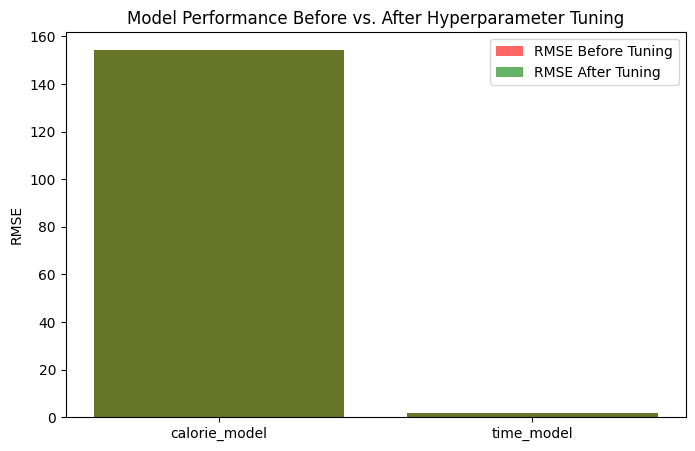

In [19]:
# Data for plotting
models_list = list(models.keys())  # ["calorie_model", "time_model"]
rmse_before = [pre_tuned_rmse[model] for model in models_list]
rmse_after = [post_tuned_rmse[model] for model in models_list]

# Create bar chart comparison
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models_list, rmse_before, color='red', alpha=0.6, label="RMSE Before Tuning")
ax.bar(models_list, rmse_after, color='green', alpha=0.6, label="RMSE After Tuning")

# Labels & formatting
ax.set_ylabel("RMSE")
ax.set_title("Model Performance Before vs. After Hyperparameter Tuning")
ax.legend()
plt.show()

## 4. Model evaluation

In [20]:
# Your code here... Make predictions on the test set with the optimized time and calorie models.
# Then evaluate those predictions - plotting predicted vs true values and/or fit residuals is
# a good idea, you also probably want to look at the RMSE between predictions and labels 

# Apply evaluation for both models
post_tuned_rmse = {}
for model_name, model in models.items():
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    post_tuned_rmse[model_name] = model_func.evaluate_model(model, X_test, y_test, model_name)

calorie_model RMSE: 154.06
time_model RMSE: 1.88


In [21]:
# Apply evaluation for both models
post_tuned_r2 = {}
for model_name, model in models.items():
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    post_tuned_r2[model_name] = model_func.evaluate_r2(model, X_test, y_test, model_name)

calorie_model R² Score: 0.96
time_model R² Score: 0.97


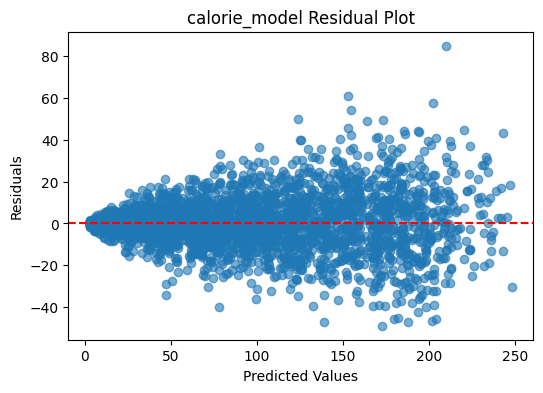

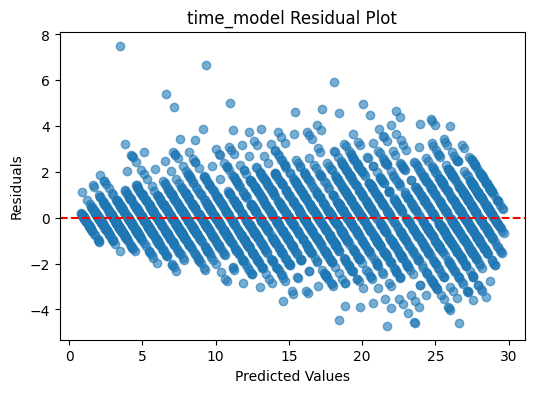

In [22]:
# Apply residual analysis for both models
for model_name, model in models.items():
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    plotting.plot_residuals(model, X_test, y_test, model_name)

## 5. Save assets

In [23]:
Path('../models').mkdir(exist_ok=True)

with open('../models/optimized_models.pkl', 'wb') as output_file:
    pickle.dump(models, output_file)

with open('../models/optimized_hyperparameters.pkl', 'wb') as output_file:
    pickle.dump(optimized_hyperparameters, output_file)